# Diffusion Models in Depth - Implementation of a diffusion model for ___ using PyTorch

Necessary imports

In [28]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from PIL import Image

from utils import utils

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

In [29]:
if torch.cuda.is_available():
    device = torch.device("cuda")           # GPU
elif torch.backends.mps.is_available():     
    device = torch.device("mps")            # Metal (for M-series Macs)
else:
    device = torch.device("cpu")            # CPU

print(f"Using device: {device}")

Using device: mps


In [32]:
torch.random.manual_seed(0)

img = Image.open("data/food-101/images/baklava/788.jpg")

print(img.size)

(512, 384)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


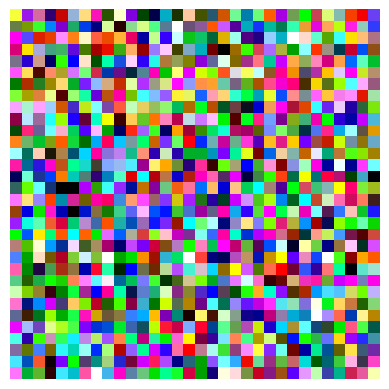

In [18]:
f = utils.cosine_scheduler
s = 0.008
alpha_prod = f(1000, 1000, s) / f(0, 1000, s)
alpha_prod = torch.tensor(alpha_prod, dtype=torch.float32)

x_0 = images[0].to(device)

mu = torch.sqrt(alpha_prod) * x_0
noise = torch.sqrt(1 - alpha_prod) * torch.randn_like(x_0)

x_t = mu + noise

imshow(x_t.to("cpu"))